In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
# Download necessary NLTK data
import nltk
from jupyter_core.version import pattern

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load and display the data


In [2]:
# Define the path to the manually downloaded dataset
data_path = "data/data.csv"  # Update the file name if it's different

# Check if the file exists before attempting to load
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset file not found at {data_path}. Ensure the file is in the correct location.")

# Load the dataset
df= pd.read_csv(data_path)
print("Dataset loaded successfully!")

# Display the first few rows of the DataFrame
df.head()


Dataset loaded successfully!


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


# Perform EDA 

# Display class disctribution

Class distribution:
Sentiment
neutral     3124
positive    1852
negative     860
Name: count, dtype: int64

Text length stats:
count    5836.000000
mean      116.964702
std        56.318951
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: text_length, dtype: float64


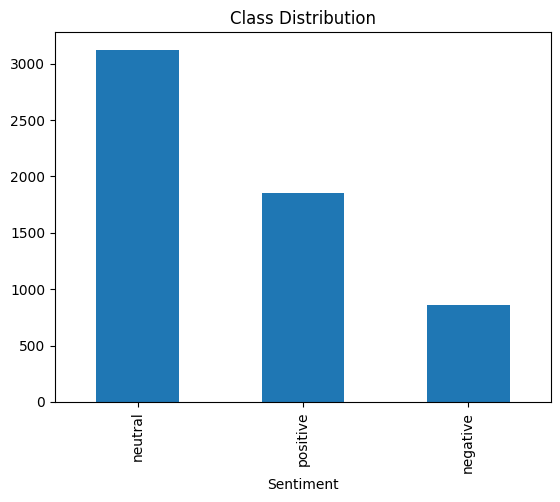

In [3]:
import matplotlib.pyplot as plt
# Perform Exploratory Data Analysis (EDA)
# drop rows with missing values
df.dropna(inplace=True)
# Check for duplicates and remove them
df.drop_duplicates(inplace=True)
def perform_eda(data):
    # Check class distribution
    print("Class distribution:")
    print(df['Sentiment'].value_counts())

    # Text length analysis
    df['text_length'] = df['Sentence'].apply(len)
    print("\nText length stats:")
    print(df['text_length'].describe())

    # Visualize class distribution
    df['Sentiment'].value_counts().plot(kind='bar', title="Class Distribution")
    plt.show()
perform_eda(df)


# Preprocess the text data


In [ ]:
import nltk
import re
import html


# Download necessary NLTK resources if not already done
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_df(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Decode HTML entities
    text = html.unescape(text)

    # Replace URLs with a placeholder
    text = re.sub(r'http\S+|www\S+|https\S+', 'url', text)

    # Strip leading/trailing whitespace
    return text.strip()
    

# Apply the cleaning function to the 'Sentence' column and create a new column 'cleaned_text'
df['cleaned_text'] = df['Sentence'].apply(clean_df)
df.head(100)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Sentence,Sentiment,text_length,cleaned_text
0,The GeoSolutions technology will leverage Bene...,positive,218,The GeoSolutions technology will leverage Bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55,"$ESI on lows, down $1.50 to $2.50 BK a real po..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,193,"For the last quarter of 2010 , Componenta 's n..."
3,According to the Finnish-Russian Chamber of Co...,neutral,128,According to the Finnish-Russian Chamber of Co...
4,The Swedish buyout firm has sold its remaining...,neutral,135,The Swedish buyout firm has sold its remaining...
...,...,...,...,...
95,M-Real said there are ` no grounds ' for the r...,neutral,117,M-Real said there are ` no grounds ' for the r...
96,Lember said the matter was topical also in Est...,neutral,173,Lember said the matter was topical also in Est...
97,- Moody 's said it gave P A1 long-term senior ...,neutral,193,- Moody 's said it gave P A1 long-term senior ...
98,$TSLA recall,negative,12,$TSLA recall


# Handle imbalance

In [5]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Χαρτογράφηση των labels σε ακέραιους
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
df['label'] = df['Sentiment'].map(label_mapping)

# Προετοιμασία δεδομένων
texts = df['cleaned_text'].tolist()
labels = df['label'].tolist()

# Train/Validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# Υπολογισμός class weights βάσει του training set
train_labels_np = np.array(train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_np),
    y=train_labels_np
)


class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Εκτύπωση για έλεγχο
print("Class weights:", class_weights_tensor)


Class weights: tensor([1.0506, 2.2616, 0.6226])


# focal loss function from 
code was found on github page https://github.com/itakurah/Focal-loss-PyTorch

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean', task_type='binary', num_classes=None):
        """
        Unified Focal Loss class for binary, multi-class, and multi-label classification tasks.
        :param gamma: Focusing parameter, controls the strength of the modulating factor (1 - p_t)^gamma
        :param alpha: Balancing factor, can be a scalar or a tensor for class-wise weights. If None, no class balancing is used.
        :param reduction: Specifies the reduction method: 'none' | 'mean' | 'sum'
        :param task_type: Specifies the type of task: 'binary', 'multi-class', or 'multi-label'
        :param num_classes: Number of classes (only required for multi-class classification)
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.task_type = task_type
        self.num_classes = num_classes

        # Handle alpha for class balancing in multi-class tasks
        if task_type == 'multi-class' and alpha is not None and isinstance(alpha, (list, torch.Tensor)):
            assert num_classes is not None, "num_classes must be specified for multi-class classification"
            if isinstance(alpha, list):
                self.alpha = torch.Tensor(alpha)
            else:
                self.alpha = alpha

    def forward(self, inputs, targets):
        """
        Forward pass to compute the Focal Loss based on the specified task type.
        :param inputs: Predictions (logits) from the model.
                       Shape:
                         - binary/multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size, num_classes)
        :param targets: Ground truth labels.
                        Shape:
                         - binary: (batch_size,)
                         - multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size,)
        """
        if self.task_type == 'binary':
            return self.binary_focal_loss(inputs, targets)
        elif self.task_type == 'multi-class':
            return self.multi_class_focal_loss(inputs, targets)
        elif self.task_type == 'multi-label':
            return self.multi_label_focal_loss(inputs, targets)
        else:
            raise ValueError(
                f"Unsupported task_type '{self.task_type}'. Use 'binary', 'multi-class', or 'multi-label'.")

    def binary_focal_loss(self, inputs, targets):
        """ Focal loss for binary classification. """
        probs = torch.sigmoid(inputs)
        targets = targets.float()

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weighting
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_class_focal_loss(self, inputs, targets):
        """ Focal loss for multi-class classification. """
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)

        # Convert logits to probabilities with softmax
        probs = F.softmax(inputs, dim=1)

        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute cross-entropy for each class
        ce_loss = -targets_one_hot * torch.log(probs)

        # Compute focal weight
        p_t = torch.sum(probs * targets_one_hot, dim=1)  # p_t for each sample
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided (per-class weighting)
        if self.alpha is not None:
            alpha_t = alpha.gather(0, targets)
            ce_loss = alpha_t.unsqueeze(1) * ce_loss

        # Apply focal loss weight
        loss = focal_weight.unsqueeze(1) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_label_focal_loss(self, inputs, targets):
        """ Focal loss for multi-label classification. """
        probs = torch.sigmoid(inputs)

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weight
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


# Create model 
the model we will use is finbert 

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoConfig
from transformers import TrainerCallback, EarlyStoppingCallback
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# Tokenizer και model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

config = AutoConfig.from_pretrained(
    "ProsusAI/finbert",
    num_labels=3,
    hidden_dropout_prob=0.3,               
    attention_probs_dropout_prob=0.3       
)

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",config=config)

# Dataset class
class FinDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)






# Tokenization
train_enc = tokenizer(train_texts, truncation=True, padding='max_length', max_length=160)
val_enc = tokenizer(val_texts, truncation=True, padding='max_length', max_length=160)

# Datasets
train_dataset = FinDataset(train_enc, train_labels)
val_dataset = FinDataset(val_enc, val_labels)

# Metrics function για accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Custom Trainer class for Focal Loss
class MyTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.model.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        if self.class_weights is not None:
            loss_fct = FocalLoss(
                gamma=2,
                alpha=self.class_weights * 3,
                reduction='mean',
                task_type='multi-class',
                num_classes=3
            )
            loss = loss_fct(logits, labels)
        else:
            loss = outputs.loss
        return (loss, outputs) if return_outputs else loss
    
class SaveMetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # Called at the end of evaluation
        if 'eval_loss' in metrics:
            self.val_loss.append(metrics['eval_loss'])
        if 'eval_accuracy' in metrics:
            self.val_acc.append(metrics['eval_accuracy'])

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Called during training logging
        if logs is not None:
            if 'loss' in logs:
                self.train_loss.append(logs['loss'])
            if 'accuracy' in logs:
                self.train_acc.append(logs['accuracy'])

    
save_metrics_callback = SaveMetricsCallback()   
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    learning_rate=1e-5,
    weight_decay=0.02,
    lr_scheduler_type="reduce_lr_on_plateau",      
    warmup_ratio=0.1,                   
)

# Trainer
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
    callbacks=[
        save_metrics_callback,
        EarlyStoppingCallback(early_stopping_patience=3)
    ]
)

# Train the model
trainer.train()

# measure train and validation metrics
train_metrics = trainer.evaluate(train_dataset)
val_metrics = trainer.evaluate(val_dataset)

print(f"Train Loss: {train_metrics['eval_loss']:.4f}, Train Accuracy: {train_metrics['eval_accuracy']:.4f}")
print(f"Val Loss: {val_metrics['eval_loss']:.4f}, Val Accuracy: {val_metrics['eval_accuracy']:.4f}")


c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
W0612 15:30:41.263000 22856 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\mateo\anaconda3\envs\deepL\Lib\site-

{'loss': 0.2769, 'learning_rate': 1e-05, 'epoch': 1.0}


                                                
 10%|█         | 73/730 [00:34<04:47,  2.29it/s]

{'eval_loss': 0.16184423863887787, 'eval_accuracy': 0.809931506849315, 'eval_runtime': 2.7632, 'eval_samples_per_second': 422.703, 'eval_steps_per_second': 6.876, 'epoch': 1.0}


 20%|██        | 146/730 [01:07<04:10,  2.33it/s]

{'loss': 0.1961, 'learning_rate': 1e-05, 'epoch': 2.0}


                                                 
 20%|██        | 146/730 [01:10<04:10,  2.33it/s]

{'eval_loss': 0.14950716495513916, 'eval_accuracy': 0.815068493150685, 'eval_runtime': 2.7574, 'eval_samples_per_second': 423.594, 'eval_steps_per_second': 6.891, 'epoch': 2.0}


 30%|███       | 219/730 [01:43<03:39,  2.33it/s]

{'loss': 0.179, 'learning_rate': 1e-05, 'epoch': 3.0}


                                                 
 30%|███       | 219/730 [01:45<03:39,  2.33it/s]

{'eval_loss': 0.13509927690029144, 'eval_accuracy': 0.815068493150685, 'eval_runtime': 2.7568, 'eval_samples_per_second': 423.687, 'eval_steps_per_second': 6.892, 'epoch': 3.0}


 40%|████      | 292/730 [02:18<03:08,  2.32it/s]

{'loss': 0.1589, 'learning_rate': 1e-05, 'epoch': 4.0}


                                                 
 40%|████      | 292/730 [02:21<03:08,  2.32it/s]

{'eval_loss': 0.14337772130966187, 'eval_accuracy': 0.8202054794520548, 'eval_runtime': 2.7601, 'eval_samples_per_second': 423.18, 'eval_steps_per_second': 6.884, 'epoch': 4.0}


 50%|█████     | 365/730 [02:54<02:36,  2.33it/s]

{'loss': 0.1442, 'learning_rate': 1e-05, 'epoch': 5.0}


                                                 
 50%|█████     | 365/730 [02:57<02:36,  2.33it/s]

{'eval_loss': 0.13506539165973663, 'eval_accuracy': 0.8227739726027398, 'eval_runtime': 2.7578, 'eval_samples_per_second': 423.527, 'eval_steps_per_second': 6.89, 'epoch': 5.0}


 60%|██████    | 438/730 [03:29<02:05,  2.33it/s]

{'loss': 0.1406, 'learning_rate': 1e-05, 'epoch': 6.0}


                                                 
 60%|██████    | 438/730 [03:32<02:05,  2.33it/s]

{'eval_loss': 0.14048221707344055, 'eval_accuracy': 0.8056506849315068, 'eval_runtime': 2.7551, 'eval_samples_per_second': 423.947, 'eval_steps_per_second': 6.896, 'epoch': 6.0}


 70%|███████   | 511/730 [04:05<01:33,  2.33it/s]

{'loss': 0.1317, 'learning_rate': 1e-05, 'epoch': 7.0}


                                                 
 70%|███████   | 511/730 [04:08<01:33,  2.33it/s]

{'eval_loss': 0.1445528119802475, 'eval_accuracy': 0.8013698630136986, 'eval_runtime': 2.7618, 'eval_samples_per_second': 422.915, 'eval_steps_per_second': 6.88, 'epoch': 7.0}


 80%|████████  | 584/730 [04:41<01:02,  2.33it/s]

{'loss': 0.1215, 'learning_rate': 1e-05, 'epoch': 8.0}


                                                 
 80%|████████  | 584/730 [04:43<01:02,  2.33it/s]

{'eval_loss': 0.14118200540542603, 'eval_accuracy': 0.8159246575342466, 'eval_runtime': 2.7576, 'eval_samples_per_second': 423.559, 'eval_steps_per_second': 6.89, 'epoch': 8.0}


 80%|████████  | 584/730 [04:45<01:11,  2.05it/s]


{'train_runtime': 285.0976, 'train_samples_per_second': 163.733, 'train_steps_per_second': 2.561, 'train_loss': 0.16862748257101398, 'epoch': 8.0}


100%|██████████| 19/19 [00:02<00:00,  7.33it/s]

Train Loss: 0.1100, Train Accuracy: 0.8353
Val Loss: 0.1351, Val Accuracy: 0.8228


100%|██████████| 19/19 [00:02<00:00,  7.33it/s]

Validation Classification Report:
              precision    recall  f1-score   support

    positive       0.88      0.90      0.89       371
    negative       0.53      0.92      0.67       172
     neutral       0.96      0.75      0.84       625

    accuracy                           0.82      1168
   macro avg       0.79      0.86      0.80      1168
weighted avg       0.87      0.82      0.83      1168



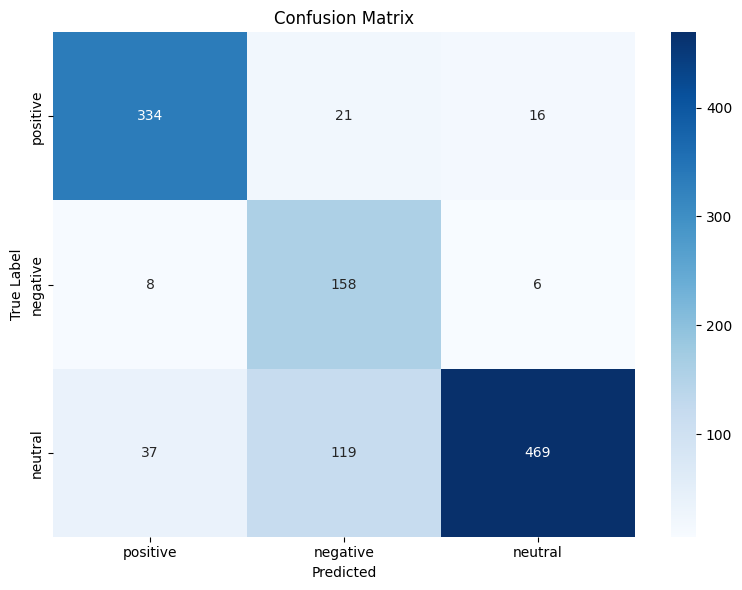

In [8]:
# print classification report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_preds = trainer.predict(val_dataset)
val_preds = np.argmax(val_preds.predictions, axis=1)
print("Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['positive', 'negative', 'neutral']))

# confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [9]:
# macro avg
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score ,accuracy_score
macro_f1 = f1_score(val_labels, val_preds, average='weighted')
macro_precision = precision_score(val_labels, val_preds, average='weighted')
macro_recall = recall_score(val_labels, val_preds, average='weighted')
macro_accuracy = accuracy_score(val_labels, val_preds)
print(f"Weighted Accuracy: {macro_accuracy:.4f}")
print(f"Weighted F1 Score: {macro_f1:.4f}")
print(f"Weighted Precision: {macro_precision:.4f}")
print(f"Weighted Recall: {macro_recall:.4f}")

Weighted Accuracy: 0.8228
Weighted F1 Score: 0.8317
Weighted Precision: 0.8691
Weighted Recall: 0.8228


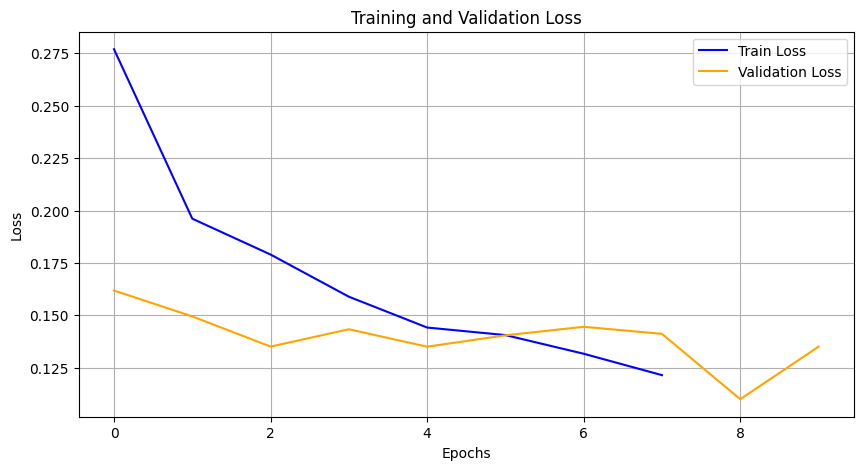

In [13]:
# plot training loss
import matplotlib.pyplot as plt
def plot_training_loss(callback):
    plt.figure(figsize=(10, 5))
    plt.plot(callback.train_loss, label='Train Loss', color='blue')
    plt.plot(callback.val_loss, label='Validation Loss', color='orange')
    plt.title('Training Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_training_loss(save_metrics_callback)





In [11]:
# print model architecture
print(model)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,